In [262]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Question 1

Examine transactions data  

In [263]:
transactions = pd.read_table('transactions.tsv')

In [264]:
transactions.head()

,transaction.value,gender,store.type
0,33.80,Male,Metro
1,7.02,Male,Superstore
2,335.88,Female,Extra
3,79.02,Male,Superstore
4,354.15,Male,Metro


In [265]:
transactions.describe()

,transaction.value
count,2000.000000
mean,286.176050
std,4042.830224
min,0.460000
25%,22.127500
50%,47.275000
75%,173.665000
max,150032.000000


In [266]:
transactions['transaction.value'].mean()

286.17605

The max value of £150032 seems like an outlier. See what average spend is when outliers are removed.

### Find Outliers

In [267]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))


def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote])):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote])):
        tfOutlier = list(zip(x, func(x)))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['spend', 'outlier'])
    if replace == 'median':
        replace = x.choice.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    spendNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            spendNew.append(replace)
        else:
            spendNew.append(x.iloc[i][0])
    
    return spendNew

Examine transactions['transaction.value'] for outliers

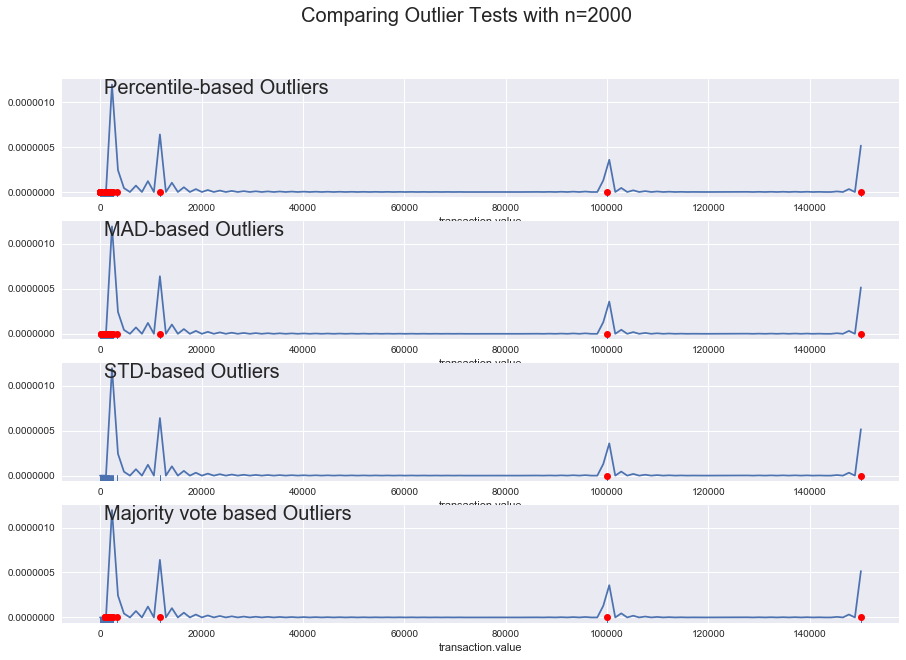

In [268]:
plotOutlier(transactions['transaction.value'].sample(2000))

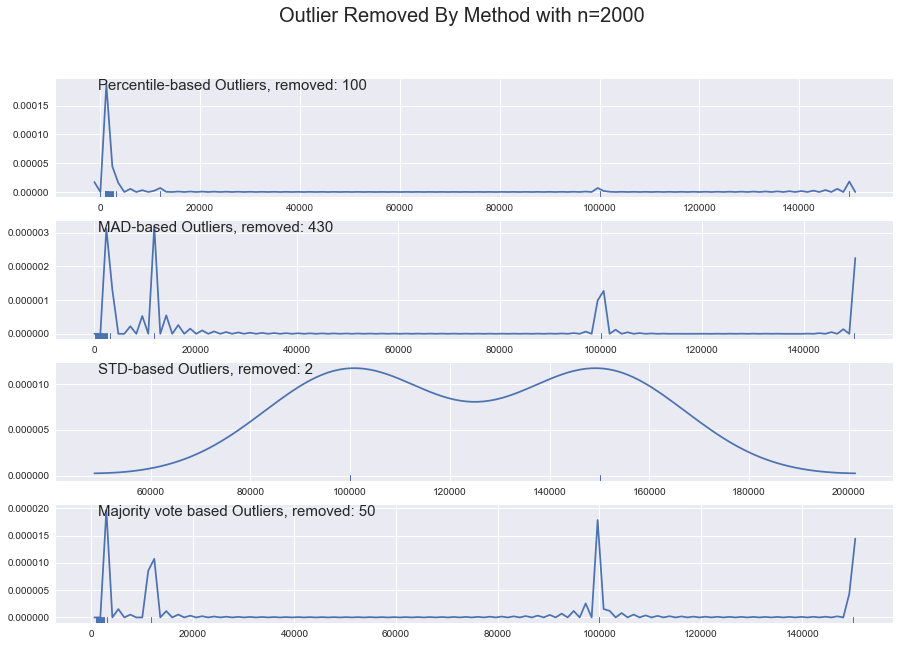

In [269]:
plotOutlierFree(transactions['transaction.value'].sample(2000))

Remove outliers from the transaction.value column by outlierVote classifier and replace them with a high fixed value

In [270]:
newTransactionValue = replaceOutlier(transactions['transaction.value'], replace='minUpper')

In [271]:
transactions['transaction.value'] = newTransactionValue

In [272]:
transactions.describe()

,transaction.value
count,2000.000000
mean,147.199700
std,215.875071
min,0.460000
25%,22.127500
50%,47.275000
75%,173.665000
max,973.400000


### Average spend with outliers removed is £147.20

### Question 2

Group data by store and get summary statistics to see if there is a significant difference in 
spend betweeen different stores.  

In [273]:
transactions.groupby('store.type').describe()

transaction.value                                                  \
                       count        mean         std   min      25%      50%   
store.type                                                                     
Express                282.0   83.328972  174.060415  5.13  15.3950   25.795   
Extra                  402.0  229.490025  273.901802  0.46  33.2075  111.150   
Metro                  487.0  110.542177  199.682970  2.75  16.7350   27.760   
Superstore             829.0  150.556815  192.383074  3.14  34.3900   71.500   

                             
                 75%    max  
store.type                   
Express      41.2425  973.4  
Extra       338.2750  973.4  
Metro        54.0750  973.4  
Superstore  177.4600  973.4

On average, there is a significant difference in the spend at Extra. Most of the customers spend ~50% more than at  
Express, Metro or Superstore.

### Question 3

In [274]:
content_train = pd.read_table('content_train.tsv')

In [275]:
content_test = pd.read_table('content_test.tsv')

In [276]:
#content_train.describe()
#content_test.describe()

In [277]:
content = pd.concat([content_train, content_test])

Change the affluency, gender and county columns to categories and drop the columns.  
Assume all the customers saw all the marketing content items similar to content_test.tsv  

In [278]:
for col in ['gender', 'affluency', 'county']:
    content[col] = content[col].astype('category')

In [279]:
content['gendercode'] = content.gender.cat.codes

In [280]:
content['afluencycode'] = content.affluency.cat.codes

In [281]:
content['countycode'] = content.county.cat.codes

In [282]:
content.drop(['gender', 'affluency', 'county'], axis=1, inplace=True)

In [283]:
content = content.fillna(0.0)

In [284]:
#content.head()
#content.dtypes
#content.describe()

Check outlier ratio for the columns, remove outliers and replace with a fixed high value, swap columns, plot a few.  
The transactions numbers seem ok from store to store but there are some very large numbers for the  
total spend.

In [285]:
outlierRatio(content['direct.total.spend'])

{'mad_based_outlier': [8582, '7.15%'],
 'outlierVote': [4267, '3.56%'],
 'percentile_based_outlier': [3000, '2.50%'],
 'std_div': [4267, '3.56%']}

In [286]:
content['direct.total.spend'] = replaceOutlier(content['direct.total.spend'], replace='minUpper')

In [287]:
content['express.total.spend'] = replaceOutlier(content['express.total.spend'], replace='minUpper')

In [288]:
content['extra.total.spend'] = replaceOutlier(content['extra.total.spend'], replace='minUpper')

In [289]:
content['fandf.total.spend'] = replaceOutlier(content['fandf.total.spend'], replace='minUpper')

In [290]:
content['metro.total.spend'] = replaceOutlier(content['metro.total.spend'], replace='minUpper')

In [291]:
content['petrol.total.spend'] = replaceOutlier(content['petrol.total.spend'], replace='minUpper')

In [292]:
content['superstore.total.spend'] = replaceOutlier(content['superstore.total.spend'], replace='minUpper')

Split back into train and predict sets

In [293]:
content_train = content[:100000]
content_test = content[100000:]

In [294]:
#content_train.describe()

In [295]:
#content_test.describe()
#content_test.tail()

### Split training data

In [329]:
X = content_train.drop('content_1', axis=1)
y = content_train.content_1

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [331]:
y_test.head()

34858    0.0
79417    0.0
40476    0.0
71526    0.0
36308    0.0
Name: content_1, dtype: float64

In [166]:
def cvDictGen(functions, scr, X_train=X_train, y_train=y_train, cv=3, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[list(cvDict.keys())[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[list(cvDict.keys())[0]][1]))]
    return cvDictNormalized

### Predictions

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [171]:
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)

In [172]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [173]:
adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0)

In [174]:
gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [175]:
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0)

In [176]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, rfMod], scr='roc_auc')

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.6s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.6s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s finished


In [177]:
cvDictNormalize(cvD)

{'AdaBoostClassifier': ['1.14', '191.17'],
 'GradientBoostingClassifier': ['1.09', '149.37'],
 'KNeighborsClassifier': ['1.00', '1.00'],
 'LogisticRegression': ['1.22', '55.24'],
 'RandomForestClassifier': ['1.03', '55.71']}

Try AdaBoost, GradientBoost and LogisticRegression

In [178]:
from scipy.stats import randint

### ADA

In [179]:
adaHyperParams = {'n_estimators': [10,50,100,200,400]}

In [180]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.9s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   0.9s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.9s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   5.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   5.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   4.9s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   9.9s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   9.7s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.0min finished


In [181]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 10}, 0.58240306717884582)

### GB

In [182]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [183]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] loss=exponential, max_depth=5, n_estimators=318 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=318, total=  59.6s
[CV] loss=exponential, max_depth=5, n_estimators=318 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] .. loss=exponential, max_depth=5, n_estimators=318, total=  59.1s
[CV] loss=exponential, max_depth=5, n_estimators=318 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=318, total=  57.5s
[CV] loss=deviance, max_depth=6, n_estimators=178 ....................
[CV] ..... loss=deviance, max_depth=6, n_estimators=178, total=  43.2s
[CV] loss=deviance, max_depth=6, n_estimators=178 ....................
[CV] ..... loss=deviance, max_depth=6, n_estimators=178, total=  43.8s
[CV] loss=deviance, max_depth=6, n_estimators=178 ....................
[CV] ..... loss=deviance, max_depth=6, n_estimators=178, total=  43.9s
[CV] loss=exponential, max_depth=8, n_estimators=52 ..................
[CV] ... loss=exponential, max_depth=8, n_estimators=52, total=  25.3s
[CV] loss=exponential, max_depth=8, n_estimators=52 ..................
[CV] ... loss=exponential, max_depth=8, n_estimators=52, total=  23.7s
[CV] loss=exponential, max_depth=8, n_estimators=52 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 27.0min finished


In [184]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 1, 'n_estimators': 52},
 0.60663575909507572)

### LR

In [185]:
#glmHyperParams = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [186]:
glmHyperParams = {'C': [10**-i for i in range(-5, 5)]}

In [187]:
gridSearchLR = RandomizedSearchCV(estimator=glmMod, param_distributions=glmHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=100000 ........................................................
[LibLinear][CV] ......................................... C=100000, total=   0.6s
[CV] C=100000 ........................................................
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ......................................... C=100000, total=   0.7s
[CV] C=100000 ........................................................
[LibLinear][CV] ......................................... C=100000, total=   0.8s
[CV] C=10000 .........................................................
[LibLinear][CV] .......................................... C=10000, total=   0.9s
[CV] C=10000 .........................................................
[LibLinear][CV] .......................................... C=10000, total=   1.0s
[CV] C=10000 .........................................................
[LibLinear][CV] .......................................... C=10000, total=   0.7s
[CV] C=1000 ..........................................................
[LibLinear][CV] ........................................... C=1000, total=   1.0s
[CV] C=1000 ..........................................................
[LibLinear][CV] ........................................... C=1000, total=   0.7s
[CV] C=1000

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.1s finished


In [188]:
gridSearchLR.best_params_, gridSearchLR.best_score_

({'C': 1}, 0.6042165445287232)

### Fit the best GB, ADA and LR models

In [355]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [356]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [357]:
bestGlmModFitted = gridSearchLR.best_estimator_.fit(X_train, y_train)

[LibLinear]

In [192]:
cvDictHPO = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted, bestGlmModFitted], scr='roc_auc')

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished


In [193]:
cvDictNormalize(cvDictHPO)

{'AdaBoostClassifier': ['0.96', '0.51'],
 'GradientBoostingClassifier': ['1.00', '1.00'],
 'LogisticRegression': ['1.00', '0.43']}

Plot ROC curve with CV  
PlotCvRocCurve will plot the CV ROC curve with nfolds  
rocZeroOne will compute the best cut-off point for the classifiers  

In [194]:
def plotCvRocCurve(X, y, classifier, nfolds=5):
    
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    import matplotlib.pyplot as plt
    from scipy import interp

    cv = StratifiedKFold(y, n_folds=nfolds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CV ROC curve')
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.set_size_inches(15,5)

    plt.show()

def rocZeroOne(y_true, y_predicted_porba):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted_porba[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])

    bestPoint = [fpr[dist.index(min(dist))], tpr[dist.index(min(dist))]]
    
    bestCutOff1 = thresholds[list(fpr).index(bestPoint[0])]
    bestCutOff2 = thresholds[list(tpr).index(bestPoint[1])]
    
    print ('\n' + 'Best point on the ROC: TPR = {:0.3f}%, FPR = {:0.3f}%'.format(bestPoint[1]*100, bestPoint[0]*100))
    print ('\n' + 'Best Cut-Off point: {:0.4f}'.format(bestCutOff1))

    plt.plot(dist)
    plt.xlabel('Index')
    plt.ylabel('Euclidean Distance to the perfect [0,1]')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

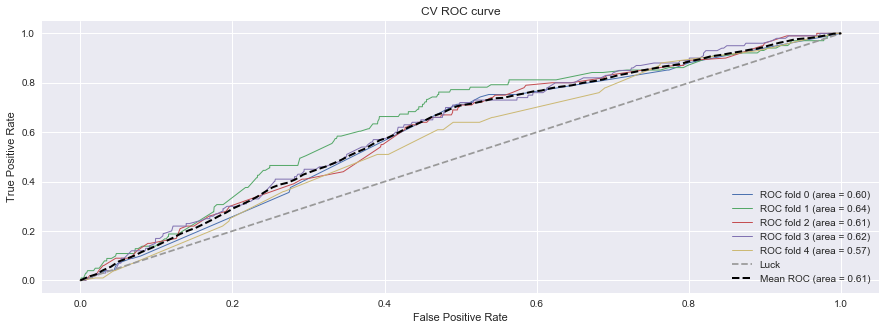

In [195]:
plotCvRocCurve(X, y, gridSearchGB.best_estimator_)


Best point on the ROC: TPR = 59.494%, FPR = 41.485%

Best Cut-Off point: 0.0065


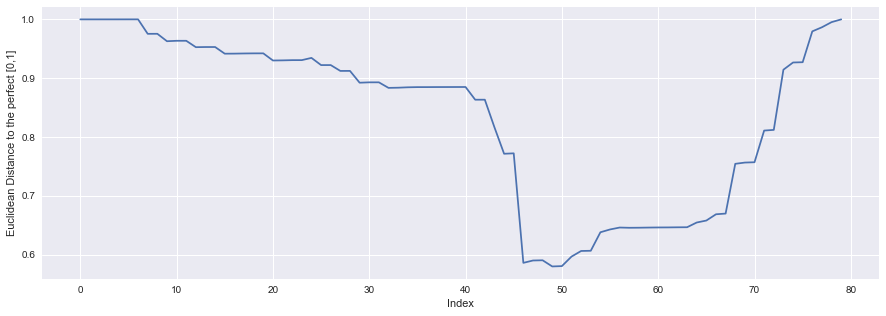

In [196]:
rocZeroOne(y_test, bestGbModFitted.predict_proba(X_test))

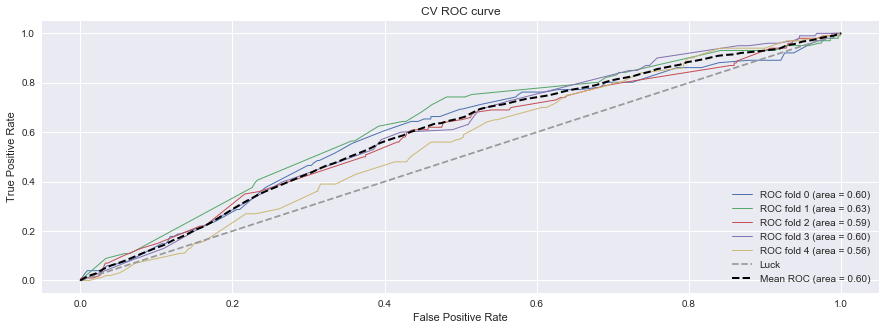

In [197]:
plotCvRocCurve(X, y, gridSearchAda.best_estimator_)


Best point on the ROC: TPR = 62.025%, FPR = 44.628%

Best Cut-Off point: 0.3783


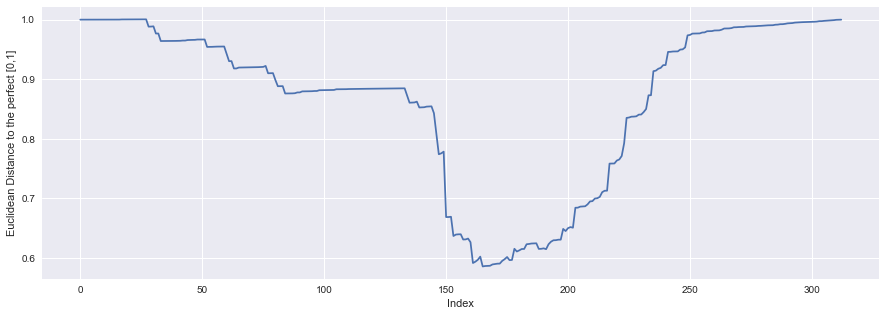

In [198]:
rocZeroOne(y_test, bestAdaModFitted.predict_proba(X_test))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

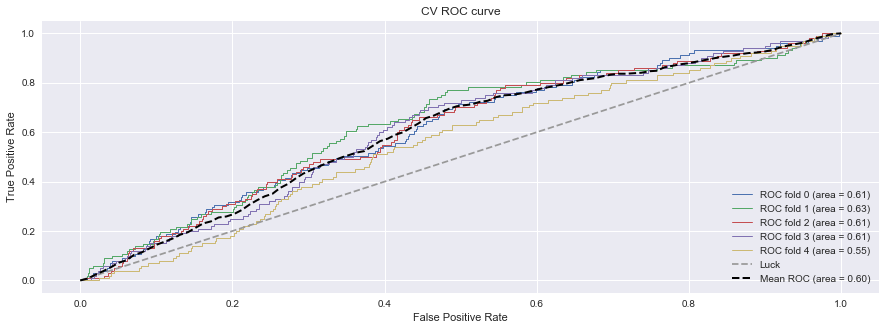

In [199]:
plotCvRocCurve(X, y, gridSearchLR.best_estimator_)


Best point on the ROC: TPR = 62.025%, FPR = 40.366%

Best Cut-Off point: 0.0057


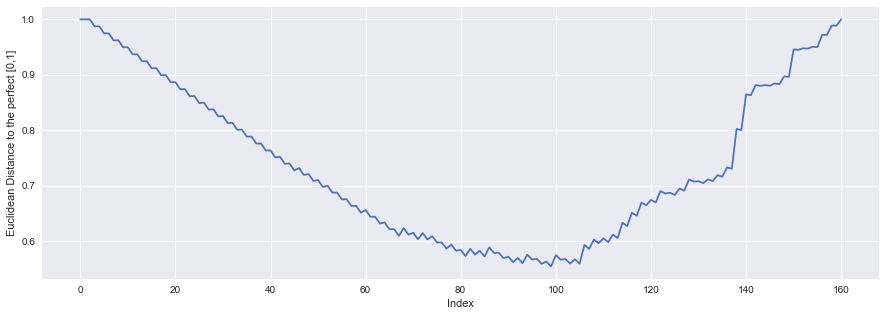

In [200]:
rocZeroOne(y_test, bestGlmModFitted.predict_proba(X_test))

### Confusion matrix

In [201]:
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print ('Classification Report:\n')
    print (classification_report(y_test, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    def plot_confusion_matrix_plot(cm, title = 'Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(y_test.unique()))
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    print ('\n Confusion matrix, without normalization: \n')
    print (cm)
    plot_confusion_matrix_plot(cm=cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('\n Normalized confusion matrix \n')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')

def makePredThresh(fittedCls, thr = 0.5, X_test=X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

### Make predicions from the GB model with the optimal threshold calculated before

In [358]:
pred = makePredThresh(bestGbModFitted, thr=0.0065)

In [359]:
plot_confusion_matrix(y_test, pred)

Classification Report:



ValueError: Found input variables with inconsistent numbers of samples: [20000, 15000]

### Make predictions from the ADA model

In [204]:
predAda = makePredThresh(bestAdaModFitted, thr=0.3783)

Classification Report:

             precision    recall  f1-score   support

        0.0       1.00      0.55      0.71     14921
        1.0       0.01      0.62      0.01        79

avg / total       0.99      0.55      0.71     15000


 Confusion matrix, without normalization: 

[[8262 6659]
 [  30   49]]

 Normalized confusion matrix 

[[ 0.55371624  0.44628376]
 [ 0.37974684  0.62025316]]


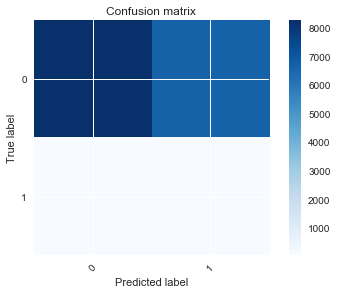

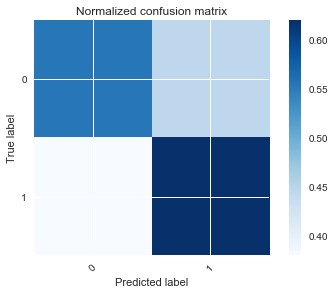

In [205]:
plot_confusion_matrix(y_test, predAda)

### Make predictions from the LR model

In [353]:
predLR = makePredThresh(bestGlmModFitted, thr=0.0057)

In [209]:
#from sklearn.metrics import log_loss

In [230]:
#log_loss(y_test, pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

Classification Report:

             precision    recall  f1-score   support

        0.0       1.00      0.60      0.75     14921
        1.0       0.01      0.62      0.02        79

avg / total       0.99      0.60      0.74     15000


 Confusion matrix, without normalization: 

[[8885 6036]
 [  30   49]]

 Normalized confusion matrix 

[[ 0.59546947  0.40453053]
 [ 0.37974684  0.62025316]]


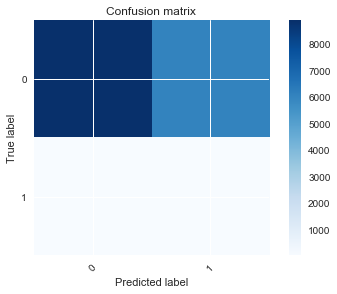

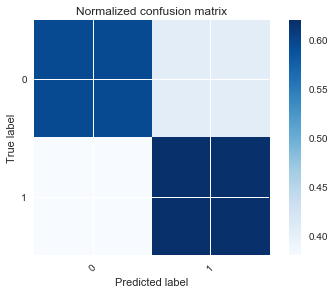

In [214]:
plot_confusion_matrix(y_test, predLR)

### Predict over content_test.tsv and create predictedLabelsSubmitted.tsv

In [344]:
#content_test.head()
#content_test.describe()

In [360]:
content_test_pred = content_test.drop('content_1', axis=1)

In [361]:
def makePredThreshCT(fittedCls, thr = 0.5, X_test=content_test_pred):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

In [362]:
predContentTest = makePredThreshCT(bestGbModFitted, thr=0.0065)

In [363]:
for x in predContentTest[:5]:
    print (x)

0
0
0
0
1


In [365]:
len(predContentTest)

20000

In [366]:
df_submitted = pd.DataFrame({'content_1':predContentTest, 'customer.id':content_test['customer.id']})

In [368]:
#df_submitted.set_index('customer.id', inplace=True)
df_submitted.head()

,content_1
customer.id,
100001,0
100002,0
100003,0
100004,0
100005,1


In [369]:
df_submitted.to_csv('submitted.tsv', sep='\t', encoding='utf-8')

### Question 4

First create a trained model and store in cloud eg gcp.  
Run distributed training in gcp.  
Use hyperparameter tuning if desired to maximize accuracy.  
Train model everyday the data changes.  
When a user signs in, check if there is a card to show recommendation for that user.  
If there is, show user the card.  
If there isn't, make a prediction request via api call to the model on gc ml engine.  
Ingest returned file and show user recommendation.  
Instead of running prediction for all users, we might consider a model to predict the next time a user will log on given time passed since last login.  
Use batch prediction to get predictions from card model for the users suggested by the next login model.  
Anonymize data if GDPR or other regulation\factor is an issue with using gcp.  

GCP, Docker, Kubernetes, Spark, BigQuery